In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [2]:
stock_name = "DJI"
stock = pd.read_csv("DJI.csv" )
print(stock.shape)
stock = stock['Open']

(8636, 7)


In [3]:
stock.shape

(8636,)

In [4]:
stock = stock.values.reshape([8636,1])

In [5]:
price_max = np.max(stock)
price_min = np.min(stock)

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [6]:
DJI_stock = MinMaxScaler().fit_transform(stock)

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [7]:
time_len = 10
x = []
y = []
i = 0
while(i + time_len) <= len(DJI_stock) - 1:
    x.append(DJI_stock[i:i+time_len])
    y.append(DJI_stock[i+time_len])
    i+=1

In [8]:
trainNo = int(np.ceil(len(y)*0.9))
validNo = int(np.ceil(len(y)*0.05))
x_train = np.array(x[:trainNo])
y_train = np.array(y[:trainNo])
x_valid = np.array(x[trainNo:trainNo+validNo])
y_valid = np.array(y[trainNo:trainNo+validNo])
x_test = np.array(x[trainNo+validNo:])
y_test = np.array(y[trainNo+validNo:])

In [9]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)

(7764, 10, 1)
(432, 10, 1)
(430, 10, 1)
(7764, 1)


# TesnorFlow Model

In [10]:
batch_size = 32
num_seq = 10
input_size = 1
learning_rate = 0.0005
hidden_layer = 256
epochs = 20

In [11]:
X = tf.placeholder(tf.float32, [None, num_seq, input_size])
Y = tf.placeholder(tf.float32, [None, input_size])

In [12]:
# LSTM weights
#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))
#weights for output
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [14]:
predict = []
for i in range(batch_size): 
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    for j in range(time_len):
        batch_state, batch_output = LSTM_cell(tf.reshape(X[i][j], (-1, 1)), batch_output, batch_state)
    
    predict.append(tf.matmul(batch_output, weights_output) + bias_output_layer)

In [15]:
losses = []

for i in range(len(predict)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(Y[i], (-1, 1)), predict[i]))  
    
loss = tf.reduce_mean(losses)

Instructions for updating:
Use tf.cast instead.


In [16]:
#gradients = tf.gradients(loss, tf.trainable_variables())
#clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
minimize = optimizer.minimize(loss)

# Training

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        j = 0
        while(j + batch_size) <= len(x_train):
            x_batch = x_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]      
            ct = sess.run(loss, feed_dict={X:x_batch, Y:y_batch}) 
            sess.run([minimize], feed_dict={X:x_batch, Y:y_batch})

            j+=batch_size       
        if i % 2 == 0:
            ct_v = sess.run(loss, feed_dict={X:x_valid, Y:y_valid})                
            print('Epoch {}/{}'.format(i+1, epochs), 'Training loss: {}'.format(ct),'Validation loss: {}'.format(ct_v))
    
    save_path = saver.save(sess, 'model2.ckpt')


Epoch 1/20 Training loss: 0.0002643328334670514 Validation loss: 0.0006269959849305451
Epoch 3/20 Training loss: 0.0001718749408610165 Validation loss: 0.00038982450496405363
Epoch 5/20 Training loss: 0.0013349882792681456 Validation loss: 0.0006805059965699911
Epoch 7/20 Training loss: 9.251754818251356e-05 Validation loss: 0.00010199983807979152
Epoch 9/20 Training loss: 5.7451270549790934e-05 Validation loss: 8.991821232484654e-05
Epoch 11/20 Training loss: 5.910990876145661e-05 Validation loss: 8.524185977876186e-05
Epoch 13/20 Training loss: 6.03513399255462e-05 Validation loss: 8.749245898798108e-05
Epoch 15/20 Training loss: 6.408379704225808e-05 Validation loss: 0.0001138273801188916
Epoch 17/20 Training loss: 6.74584589432925e-05 Validation loss: 0.00012651621364057064
Epoch 19/20 Training loss: 6.799235416110605e-05 Validation loss: 0.0001287204649997875


# Testing

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model2.ckpt


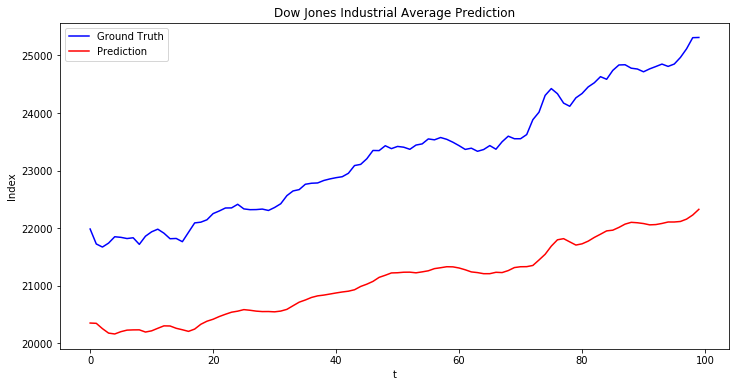

In [18]:
preds = []
i = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model2.ckpt")
    while i+batch_size <= len(x_test):
        output = sess.run(predict, feed_dict={X:x_test[i:i+batch_size]})
        i += batch_size
        preds.append(output)
    
    preds = np.squeeze(np.asarray(preds)).flatten()
    preds = preds*(price_max - price_min) + price_min
    y_test = y_test*(price_max - price_min) + price_min
    plt.figure(figsize=(12,6))
    plt.plot(range(100),y_test[0:100],color='blue')
    plt.plot(range(100),preds[0:100],color='red')
    plt.legend(['Ground Truth','Prediction'])
    plt.xlabel('t')
    plt.ylabel('Index')
    plt.title('Dow Jones Industrial Average Prediction')
    plt.show()